<a href="https://colab.research.google.com/github/RafaPierin/Meu-Primeiro-Modelo-/blob/main/Meu%20Primeiro%20Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Eu gosto de deixar todas as importações em uma célula para manter minha organização


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#Baixando dataframe pela api do YahooFinance#



df = yf.download('PETR4.SA',start = '2000-01-01', end='2024-09-11')
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-05,38.650002,38.889999,38.299999,38.299999,38.299999,26206600
2024-09-06,38.369999,38.450001,37.470001,37.549999,37.549999,32971700
2024-09-09,37.840000,38.250000,37.610001,37.959999,37.959999,30521800
2024-09-10,37.919998,37.919998,37.000000,37.330002,37.330002,37263500
2024-09-11,37.759998,37.830002,36.869999,37.360001,37.360001,22296900


In [ ]:
#Minha ideia aqui é criar novas variáveis fazendo uma média em intervalos de tempo (Médias moveis)
#Simple Moving Average(SMA), quanto maior o SMA maior a media no intervalo de tempo.
#RSI (Relative Strength Index): Indicador de momentum que mede a velocidade e a mudança dos movimentos de preços, variando de 0 a 100, e é utilizado para identificar condições de sobrecompra ou sobrevenda.
#EMA (Exponential Moving Average): Média móvel que dá mais peso aos preços mais recentes, reagindo mais rapidamente às mudanças de preço em comparação com a média móvel simples (SMA).

df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_100'] = df['Close'].rolling(window=100).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()
df['SMA_300'] = df['Close'].rolling(window=300).mean()
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()
df['EMA_300'] = df['Close'].ewm(span=300, adjust=False).mean()
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))


#Agora criarei a coluna alvo para ser feita a previsão no caso o fechamento do dia anterior vai para a coluna alvo do dia seguinte.
#Se o fechamento do dia atual for menor do que o fechamento de ontem indica queda por tanto será 0
#SE o fechamento do dia atualo for maior que o de ontem indica alta portanto será 1
df['Target'] = df['Close'].shift(1)
df.loc[df['Close'] > df['Target'],'Target'] = 1
df.tail()
df.loc[df['Target'] !=1, 'Target' ]=0
df.tail()


,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_20,SMA_50,...,SMA_300,EMA_5,EMA_10,EMA_20,EMA_50,EMA_100,EMA_200,EMA_300,RSI,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-05,38.650002,38.889999,38.299999,38.299999,38.299999,26206600,38.748000,38.817,38.282,37.8940,...,36.392733,38.620001,38.615979,38.338966,38.004211,37.963096,37.209747,36.107938,48.525067,0.0
2024-09-06,38.369999,38.450001,37.470001,37.549999,37.549999,32971700,38.384000,38.883,38.334,37.8840,...,36.414933,38.263334,38.422165,38.263826,37.986399,37.954916,37.213132,36.117519,44.042837,0.0
2024-09-09,37.840000,38.250000,37.610001,37.959999,37.959999,30521800,38.175999,38.722,38.365,37.8706,...,36.438033,38.162222,38.338135,38.234890,37.985364,37.955017,37.220564,36.129762,47.865446,1.0
2024-09-10,37.919998,37.919998,37.000000,37.330002,37.330002,37263500,37.936000,38.551,38.376,37.8470,...,36.464033,37.884815,38.154838,38.148711,37.959663,37.942640,37.221653,36.137737,45.510454,0.0
2024-09-11,37.759998,37.830002,36.869999,37.360001,37.360001,22296900,37.700000,38.327,38.356,37.8374,...,36.488300,37.709877,38.010322,38.073595,37.936147,37.931103,37.223029,36.145858,51.662064,1.0


In [ ]:
#Preciso tratar os dados nulos para que meu modelo funcione sem problemas.
df.dropna(inplace=True)
# df.isnull().sum() caso queira verificar a quanridade de dados nulos

In [ ]:
# Definindo de (x) e (y)
#Experimentei diferentes relações entr x e y e essa me trouxe 60% de acurácia.
x = df[['Close','SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200','SMA_300','RSI']]
y = df['Target']

#Dividindo treino e teste

x_treino , x_teste , y_treino , y_teste = train_test_split(x,y,test_size = 0.2,random_state=42)

In [ ]:
#Dessa vez Ultilizei o modelo Random Forest como treinamento.
modelo = RandomForestClassifier(n_estimators=100,random_state=42)

modelo.fit(x_treino,y_treino)

RandomForestClassifier(random_state=42)

In [ ]:
#Aqui eu eu fui acompanhando detalhes de funcionamento do modelo
test_predict = modelo.predict(x_teste,)

acuracia = accuracy_score(y_teste,test_predict)

print(f'Acurácia do modelo é de {acuracia*100//1}%')

print(classification_report(y_teste,test_predict))

Acurácia do modelo é de 58.0%
              precision    recall  f1-score   support

         0.0       0.57      0.60      0.59       582
         1.0       0.59      0.57      0.58       599

    accuracy                           0.58      1181
   macro avg       0.58      0.58      0.58      1181
weighted avg       0.58      0.58      0.58      1181



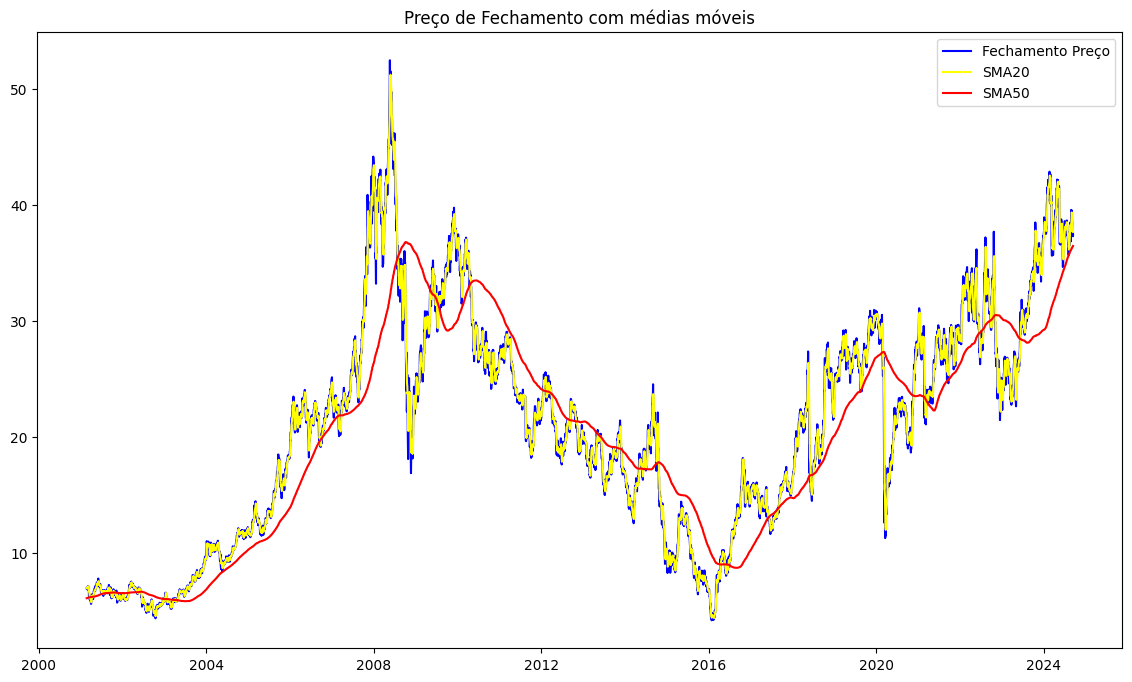

In [ ]:
# plotando a media móvel mais curta , média móvel mais longa e o fechamento em sí.
#Dessa forma consigo ter uma vizualização melhor dessas informações.
plt.figure(figsize=(14,8))
plt.plot(df['Close'],color = 'blue',label='Fechamento Preço')
plt.plot(df['SMA_5'],color = 'yellow',label='SMA20')
plt.plot(df['SMA_300'],color = 'red',label='SMA50')
plt.title('Preço de Fechamento com médias móveis')
plt.legend()

plt.show()


In [ ]:
#Agora retiramos uma amostra
amostra = df[-1::]
amostra

,Open,High,Low,Close,Adj Close,Volume,SMA_5,SMA_10,SMA_20,SMA_50,...,SMA_300,EMA_5,EMA_10,EMA_20,EMA_50,EMA_100,EMA_200,EMA_300,RSI,Target
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-11,37.759998,37.830002,36.869999,37.389999,37.389999,21563000,37.706,38.33,38.3575,37.838,...,36.4884,37.719877,38.015776,38.076452,37.937324,37.931697,37.223328,36.146057,51.862075,1.0


In [ ]:
#Nosso teste será a mesma linha que a amostra, mas não tera nosso alvo a ideia é que o nosso modelo classifique a queda ou a alta no preço da ação.
#comparamos os dados com nossa amostra.
prev = x.iloc[-1].values.reshape(1, -1)
predict = modelo.predict(prev)
prev

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[37.45000076, 37.71800003, 38.33600006, 38.36049995, 37.83919991,
        38.1341    , 38.23229996, 36.48859992]])

In [ ]:
#Aqui estou vendo como foi classificado, O modelo conseguiu acertar nessa situação, podemos ver o que ele preveu 0 e o target da amostra realmente era 0 indicando a queda

predict

array([1.])

In [ ]:
#Aqui deixaremos a resposta.
if predict == 0:
  print('Tendência de queda')
else:
  print('Tendência de Alta')

Tendência de Alta
